In [1]:
#!pip install SAS7BDAT
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statistics as stats
import matplotlib.pyplot as plt
import math
from sas7bdat import SAS7BDAT
import scipy

In [2]:
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.linear_model import Ridge, ARDRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import make_pipeline
from sklearn import metrics

import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)


# Load DataFrames from COAG

In [3]:
# Dataset 1
data_path = '/Users/Boyla/Desktop/CollinsLab/OtherProjects/2020 Idea2Health/Prelim Data Analysis/COAG_2016a/Data/Analysis/redacted_coag_20141202_data1.sas7bdat'
foo = SAS7BDAT(data_path)
df1 = foo.to_data_frame()
dfall = df1.copy()

df1 = df1.dropna(subset=['maintain_dose'])
df1 = df1.reset_index(drop=True)

# Dataset 2
data_path = '/Users/Boyla/Desktop/CollinsLab/OtherProjects/2020 Idea2Health/Prelim Data Analysis/COAG_2016a/Data/Analysis/redacted_coag_20141202_data2.sas7bdat'
#data_path = '/Users/adamkrekorian/Desktop/Collins_Lab/Data/COAG_2016a/Data/Analysis/redacted_coag_20141202_data2.sas7bdat'
foo = SAS7BDAT(data_path)
df2 = foo.to_data_frame()
df2 = df2.dropna()

# Dataset 7
data_path = '/Users/Boyla/Desktop/CollinsLab/OtherProjects/2020 Idea2Health/Prelim Data Analysis/COAG_2016a/Data/Analysis/redacted_coag_20141208_data7.sas7bdat'
#data_path = '/Users/adamkrekorian/Desktop/Collins_Lab/Data/COAG_2016a/Data/Analysis/redacted_coag_20141208_data7.sas7bdat'
foo = SAS7BDAT(data_path)
df7 = foo.to_data_frame()

df7 = df7[['new_pid', 'SDAY', 'INR', 'ADOSE']]
df7 = df7.sort_values(['new_pid', 'SDAY'], ascending=(True, True))
df7 = df7.dropna()

In [4]:
#fix races
races= np.array([1, 2, 3, 4])
race_names = ['AA_racec', 'Caucasian_racec', 'Asian_racec', 'Other_racec']
for num in races:
    df1[race_names[num - 1]] = (df1['racec']==(num)).astype('int64', copy=False)

df1 = df1[['new_pid', 'Age','male','Weight','AA_racec', 'Caucasian_racec', 'Asian_racec', 'Other_racec', 'maintain_dose']]
df1.rename(columns={'Weight':'weight'}, inplace = True)
df1.rename(columns={'AA_racec':'AA'}, inplace = True)
df1.rename(columns={'Caucasian_racec':'white'}, inplace = True)
df1.rename(columns={'Asian_racec':'asian'}, inplace = True)
df1.rename(columns={'Other_racec':'other_race'}, inplace = True)
df1['age']=  (df1['Age'].map(lambda num: num // 10)).astype('int64', copy=False)
df1['male']=  (df1['male']).astype('int64', copy=False)
df1 =  df1.drop(['Age'], axis=1)

In [5]:
df7['PREV_INR'] = df7['INR'].shift(1)                         #INR_(t-1)
df7['PREV_DOSE'] = df7['ADOSE'].shift(1)                      #Dose(t-1)
df7['PREV1_DOSE'] = df7['ADOSE'].shift(2)                      #Dose(t-2)
df7['PREV2_DOSE'] = df7['ADOSE'].shift(3)                      #Dose(t-3)

df7['DAY_DIFF'] = df7['SDAY'] - df7['SDAY'].shift(1)          #Day_t - Day_(t-1)
df7['INR_DIFF'] = df7['INR'] - df7['INR'].shift(1)            #INR_t - Day_(t-1)

df7['NEXT_ADOSE'] = df7['ADOSE'].shift(-1)                    #Dose_(t+1)
df7['NEXT_INR'] = df7['INR'].shift(-1)                        #INR_(t+1)

df7['NEXTNEXT_ADOSE'] = df7['ADOSE'].shift(-2)                #Dose(t+2)
df7['NEXTNEXT_INR'] = df7['INR'].shift(-2)                    #INR(t+2)

df7['DAY1_DIFF'] = df7['SDAY'].shift(-1) - df7['SDAY']           #Day_(t+1) - Day_(t)
df7['DAY2_DIFF'] = df7['SDAY'].shift(-2) - df7['SDAY'].shift(-1) #Day_(t+2) - Day_(t+1)

df7['DELTA_DOSE'] =  df7['INR'] - df7['NEXT_INR'] 
df7['DELTA_INR'] =  df7['ADOSE'] - df7['PREV_DOSE'] 

df_c = df7.merge(df1, left_on='new_pid', right_on='new_pid')
print(df_c.shape)
df_c = df_c.drop(df_c[df_c['DAY_DIFF'] < 1].index)
print(df_c.shape)
df_c = df_c.dropna()

print(df7['DELTA_INR'] )


(5185, 26)
(4570, 26)
3        NaN
2        0.0
4        2.0
5        0.0
1       10.0
8      -11.0
9        0.0
10      -3.0
11       4.0
12       0.0
6       -4.0
15      -6.0
13       7.0
14      -7.0
16       0.0
17       3.0
18       3.0
22      -1.0
24       0.0
30      -2.0
25       2.0
27       0.0
31       1.0
28      -1.0
26       0.0
29       1.0
36      -1.0
38      -1.0
33       0.0
37      -1.0
        ... 
9335     4.0
9336    -1.0
9337     0.0
9330     1.0
9338     0.0
9339    -1.0
9346    -4.0
9341     6.0
9343    -4.5
9347     0.0
9349     0.0
9348     0.5
9351    -2.0
9356     0.0
9359     0.0
9358    -3.0
9354    -0.5
9352     1.5
9363     0.0
9367     1.0
9360     0.0
9368     0.0
9361    -2.5
9364     2.5
9376     2.5
9372     4.5
9378     8.0
9371   -10.0
9377     5.0
9379    -5.0
Name: DELTA_INR, Length: 6511, dtype: float64


In [6]:
df_c1 = df_c[df_c['SDAY'] < 11]
df_c2 = df_c1[df_c1['SDAY'] > 6]
df_c3 = df_c2[df_c2['DAY_DIFF'] < 6]
df_c4 = df_c3.drop_duplicates(subset='new_pid', keep='first', inplace=False)

df2 = df2.dropna(subset=['clinical_dose4_5'])
df2_clean = df2[['new_pid', 'clinical_dose4_5']]
s1 = df2.new_pid
s2 = df_c4.new_pid
s3 = s1[s1.isin(s2)]

df_c5 = df_c4[df_c4.new_pid.isin(s3)]
df_c5 = df_c5.merge(df2_clean, left_on='new_pid', right_on='new_pid')

print(df_c.shape)
print(df_c1.shape)
print(df_c2.shape)
print(df_c3.shape)
print(df_c4.shape)
print(df_c5.shape)

(4570, 26)
(1244, 26)
(776, 26)
(775, 26)
(613, 26)
(609, 27)


In [7]:
#Clinical
X1 = df_c5[['male', 'AA', 'white',  'asian', 'other_race', 'age', 'weight']]
y1 = df_c5[['maintain_dose']].values

#Single INR1
X2 = df_c5[['PREV_DOSE','INR', 'male', 'AA', 'white',  'asian', 'other_race', 'age', 'weight']]
y2 = df_c5[['maintain_dose']].values

X3 = df_c5[['PREV1_DOSE','PREV_INR','PREV_DOSE','INR','male', 'AA', 'white',  'asian', 'other_race', 'age', 'weight']]
y3 = df_c5[['maintain_dose']].values

#Longitudinal INR2
X4 = df_c5[['PREV_DOSE','INR','ADOSE','NEXT_INR', 'male', 'AA', 'white',  'asian', 'other_race', 'age', 'weight']]
y4 =  df_c5[['maintain_dose']].values

X5 = df_c5[['ADOSE','NEXT_INR', 'male', 'AA', 'white',  'asian', 'other_race', 'age', 'weight']]
y5 =  df_c5[['maintain_dose']].values

X6 = df_c5[['ADOSE','NEXT_INR','NEXT_ADOSE','NEXTNEXT_INR', 'male', 'AA', 'white',  'asian', 'other_race', 'age', 'weight']]
y6 = df_c5[['maintain_dose']].values

df_c5.to_csv('prunedCOAGDataset.csv',index=False)

indices = np.arange(y1.shape[0])

In [8]:
def train_model(regressor, filename):
   
    X_train, X_test,y_train, y_test,indx1,idx2 = train_test_split(X1, y1, indices, test_size=0.2, random_state=0, stratify=X1[['white', 'AA', 'asian', 'other_race']])
    regressor.fit(X_train, y_train)
    y_pred1 = regressor.predict(X_test).reshape(-1,1)
    mse1 = metrics.mean_squared_error(y_test, y_pred1)
    mae1 = metrics.mean_absolute_error(y_test, y_pred1)
    
    X_train, X_test, y_train, y_test,indx1,idx2 = train_test_split(X2, y2,  indices,test_size=0.2, random_state=0, stratify=X2[['white', 'AA', 'asian', 'other_race']])
    regressor.fit(X_train, y_train)
    y_pred2 = regressor.predict(X_test).reshape(-1,1)
    mse2 = metrics.mean_squared_error(y_test, y_pred2)
    mae2 = metrics.mean_absolute_error(y_test, y_pred2)

    X_train, X_test, y_train, y_test,indx1,idx2 = train_test_split(X3, y3,  indices,test_size=0.2, random_state=0, stratify=X3[['white', 'AA', 'asian', 'other_race']])
    regressor.fit(X_train, y_train)
    y_pred3 = regressor.predict(X_test).reshape(-1,1)
    mse3 = metrics.mean_squared_error(y_test, y_pred3)
    mae3 = metrics.mean_absolute_error(y_test, y_pred3)
      
    X_train, X_test, y_train, y_test,indx1,idx2 = train_test_split(X4, y4,  indices,test_size=0.2, random_state=0, stratify=X4[['white', 'AA', 'asian', 'other_race']])
    regressor.fit(X_train, y_train)
    y_pred4 = regressor.predict(X_test).reshape(-1,1)
    mse4 = metrics.mean_squared_error(y_test, y_pred4)
    mae4 = metrics.mean_absolute_error(y_test, y_pred4)
    
    X_train, X_test, y_train, y_test,indx1,idx2 = train_test_split(X5, y5,  indices,test_size=0.2, random_state=0, stratify=X5[['white', 'AA', 'asian', 'other_race']])
    regressor.fit(X_train, y_train)
    y_pred5 = regressor.predict(X_test).reshape(-1,1)
    mse5 = metrics.mean_squared_error(y_test, y_pred5)
    mae5 = metrics.mean_absolute_error(y_test, y_pred5)

    X_train, X_test, y_train, y_test,indx1,idx2 = train_test_split(X6, y6,  indices,test_size=0.2, random_state=0, stratify=X6[['white', 'AA', 'asian', 'other_race']])
    regressor.fit(X_train, y_train)
    y_pred6 = regressor.predict(X_test).reshape(-1,1)
    mse6 = metrics.mean_squared_error(y_test, y_pred6)
    mae6 = metrics.mean_absolute_error(y_test, y_pred6)

    m = np.reshape(idx2,(idx2.shape[0],1))

    y_pred = np.concatenate((y_pred1, y_pred2, y_pred3, y_pred4, y_pred5,y_pred6, m), 1)
    np.savetxt(filename, y_pred, delimiter=',', header='feature1, feature2, feature3, feature4, feature5, feature6, pat_idx')  
    
    mse = [[mse1, mse2, mse3, mse4, mse5, mse6]]
    np.savetxt('mse' + filename, mse, delimiter=',', header='feature1, feature2, feature3, feature4, feature5, feature6')
    
    mae = [[mae1, mae2, mae3, mae4, mae5, mae6]]
    np.savetxt('mae' + filename, mae, delimiter=',', header='feature1, feature2, feature3, feature4, feature5, feature6')
    
    print(mse)
    print(mae)
    
    return [mse, mae, y_pred2,y_pred4, y_pred6]

## Linear Regression

In [9]:
linear = LinearRegression()

mseLR, maeLR,lr_pred2,lr_pred4,lr_pred6 = train_model(linear, 'linear.csv')

[[5.676168728586408, 3.26694572387017, 3.175549959169714, 1.3562377211754901, 1.4339306130981386, 1.1926945726081661]]
[[1.8772681179436852, 1.2116642508849031, 1.2101920536794764, 0.8535572689314957, 0.879979542443707, 0.8247033637268637]]


## Ridge Regression

In [10]:
ridge = Ridge(alpha = .01)

mseRR, maeRR,rr_pred2,rr_pred4,rr_pred6 = train_model(ridge,'ridge.csv')


[[5.676231045155415, 3.2667911894776, 3.1753885667576176, 1.3562367947042195, 1.4339310665178062, 1.1926663077937936]]
[[1.8772891183914664, 1.2116568386585724, 1.2101847297433226, 0.8535567062092608, 0.879981354600955, 0.824697517810096]]


## Bayesian Ridge Regression

In [11]:
bayesian_ridge = BayesianRidge(tol=1e-6)

mseBRR, maeBRR,BRR_pred2,BRR_pred4,BRR_pred6 = train_model(bayesian_ridge, 'bayesian_ridge.csv')

[[5.768085378252795, 3.1831645156988864, 3.0617386020030337, 1.3564365886457772, 1.4356071163511823, 1.1743749127441985]]
[[1.8978260609498565, 1.2083879417097256, 1.2054069297985408, 0.8536999784624847, 0.8814402521035419, 0.8188228941913901]]


## Decision Tree Regression

In [12]:
decision_tree = DecisionTreeRegressor(random_state=0, max_depth = 3)

mseDTR, maeDTR,DT_pred2,DT_pred4,DT_pred6 = train_model(decision_tree, 'decision_tree.csv')


[[6.262244715045548, 2.998870095018675, 3.1282697862782136, 2.163462998975972, 2.114683261299243, 2.117274261219898]]
[[1.9715580153723054, 1.2804165143131825, 1.2944603948716527, 1.1154056448933658, 1.077212317542726, 1.0673909539383433]]


## Gradient Boosting Regression

In [13]:
gradient_boosting = GradientBoostingRegressor(random_state=0)

mseGBR, maeGBR,GBR_pred2,GBR_pred4,GBR_pred6 = train_model(gradient_boosting, 'gradient_boosting.csv')


[[6.488077578310072, 2.031452402091807, 1.9797191466773452, 1.2877332357901832, 1.3135479140062472, 1.0790426983251402]]
[[2.036616763170433, 1.0606226560736933, 1.063512477172682, 0.8099339569214594, 0.8360704196731465, 0.7952140150279489]]


In [14]:
ard_regressor = ARDRegression(compute_score=True)

mseARD, maeARD,ARD_pred2,ARD_pred4,ARD_pred6 = train_model(ard_regressor, 'ard.csv')


[[5.70005780769294, 3.1430151601427294, 3.121513611097507, 1.2968142659354711, 1.4209190667548572, 1.1657651482342168]]
[[1.8857264747507905, 1.1971330315858555, 1.1971427317479741, 0.8436653922704019, 0.8755753942248116, 0.8201746296947087]]


## Multilayer Perceptron Regression

In [15]:
multilayer_perceptron = MLPRegressor(random_state=0, hidden_layer_sizes=[50,25], max_iter = 10000, activation = 'relu', solver = 'lbfgs')
mseMLPR, maeMLPR,mlp_pred2,mlp_pred4,mlp_pred6 = train_model(multilayer_perceptron, 'multilayer_perceptron.csv')


[[5.75495992516803, 2.070162881937624, 2.0990959059476104, 1.515412977461764, 1.5601570837153154, 1.231687949532037]]
[[1.8978525989664325, 1.0913074357964714, 1.1082687268728089, 0.9128787631264917, 0.8962687135851097, 0.8186650072103047]]


## Gage Model

In [16]:
X_train, X_test,y_train, y_test,indx1,idx2 = train_test_split(df_c5, y1, indices, test_size=0.2, random_state=0, stratify=X1[['white', 'AA', 'asian', 'other_race']])

gage_mse = metrics.mean_squared_error(X_test.maintain_dose, X_test.clinical_dose4_5)
gage_mae = metrics.mean_absolute_error(X_test.maintain_dose, X_test.clinical_dose4_5)

<Figure size 432x288 with 0 Axes>

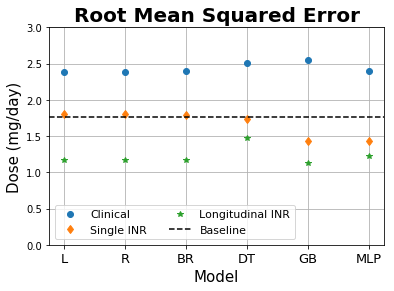

<Figure size 432x288 with 0 Axes>

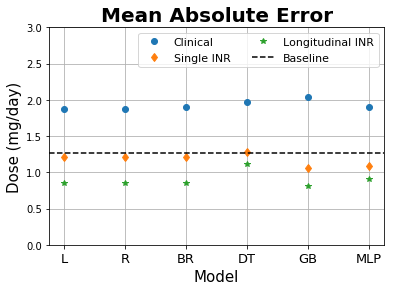

In [34]:
x = np.arange(6)

plt.figure()
fig, ax = plt.subplots()
plt.plot(np.sqrt([mseLR[0][0],mseRR[0][0],mseBRR[0][0],mseDTR[0][0],mseGBR[0][0],mseMLPR[0][0]]),'o',label= 'Clinical')
plt.plot(np.sqrt([mseLR[0][1],mseRR[0][1],mseBRR[0][1],mseDTR[0][1],mseGBR[0][1],mseMLPR[0][1]]),'d',label= 'Single INR')
plt.plot(np.sqrt([mseLR[0][3],mseRR[0][3],mseBRR[0][3],mseDTR[0][3],mseGBR[0][3],mseMLPR[0][3]]),'*',label= 'Longitudinal INR')
plt.axhline(y=np.sqrt(gage_mse), color='k', linestyle='--',label='Baseline')
plt.grid(True)
ax.set_xticks(x)
ax.set_xticklabels(['L','R','BR','DT','GB','MLP'],fontsize = 13)

plt.xlabel('Model',fontsize=15)
plt.ylabel('Dose (mg/day)',fontsize=15)
plt.title('Root Mean Squared Error',fontsize=20,fontweight = 'bold')
plt.axis([-0.25, 5.25, 0, 3])
plt.legend(fontsize= 11,ncol = 2)
plt.savefig("mseResults.png", dpi=500)

plt.figure()
fig, ax = plt.subplots()
plt.plot([maeLR[0][0],maeRR[0][0],maeBRR[0][0],maeDTR[0][0],maeGBR[0][0],maeMLPR[0][0]],'o',label= 'Clinical')
plt.plot([maeLR[0][1],maeRR[0][1],maeBRR[0][1],maeDTR[0][1],maeGBR[0][1],maeMLPR[0][1]],'d',label= 'Single INR')
plt.plot([maeLR[0][3],maeRR[0][3],maeBRR[0][3],maeDTR[0][3],maeGBR[0][3],maeMLPR[0][3]],'*',label= 'Longitudinal INR')
plt.axhline(y=gage_mae, color='k', linestyle='--',label='Baseline')

plt.grid(True)
ax.set_xticks(x)
ax.set_xticklabels(['L','R','BR','DT','GB','MLP'],fontsize = 13)

plt.xlabel('Model',fontsize=15)
plt.ylabel('Dose (mg/day)',fontsize=15)
plt.title('Mean Absolute Error',fontsize=20,fontweight = 'bold')
plt.axis([-0.25, 5.25, 0, 3])
plt.legend(fontsize= 11,ncol = 2)

plt.savefig("maeResults.png", dpi=500)

In [36]:
y_test_r = np.reshape(y_test,(y_test.shape[0],1))
GBR_pred2_r = np.reshape(y_test,(GBR_pred2.shape[0],1))
GBR_pred4_r = np.reshape(y_test,(GBR_pred4.shape[0],1))
GBR_pred6_r = np.reshape(y_test,(GBR_pred6.shape[0],1))

corrcoef_baseline = metrics.r2_score(X_test.maintain_dose, X_test.clinical_dose4_5)
corrcoef_gbr2 = metrics.r2_score(y_test, GBR_pred2)
corrcoef_gbr4 = metrics.r2_score(y_test, GBR_pred4)
corrcoef_gbr6 = metrics.r2_score(y_test, GBR_pred6)

<Figure size 432x288 with 0 Axes>

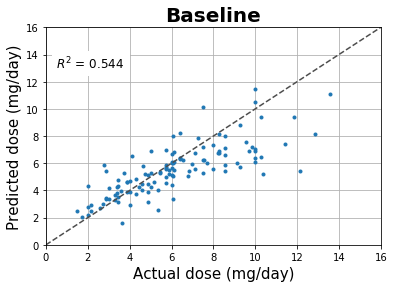

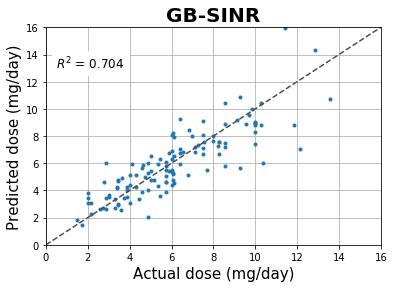

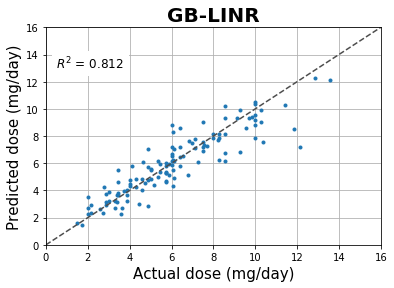

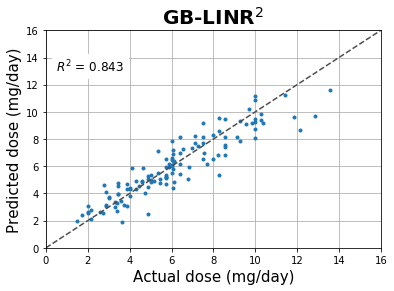

In [37]:
np.savetxt('clindoseTest.csv', X_test.clinical_dose4_5)

fig = plt.figure()
plt.show()
plt.plot(y_test,X_test.clinical_dose4_5,'.')
plt.plot([0, 16], [0, 16], ls="--", c=".3")
plt.xlabel('Actual dose (mg/day)',fontsize=15)
plt.ylabel('Predicted dose (mg/day)',fontsize=15)
plt.title('Baseline',fontsize=20,fontweight='bold')
plt.grid(True)
plt.axis([0, 16, 0, 16])
a = plt.text(0.5, 13, f"$R^2$ = {round(corrcoef_baseline,4)}", fontsize=12)
a.set_bbox(dict(facecolor='white',edgecolor='white'))
plt.savefig("scatterBaseline.png", dpi=500)

plt.figure()
plt.plot(y_test,GBR_pred2,'.')
plt.plot([0, 16], [0, 16], ls="--", c=".3")
plt.xlabel('Actual dose (mg/day)',fontsize=15)
plt.ylabel('Predicted dose (mg/day)',fontsize=15)
plt.title('GB-SINR',fontsize=20,fontweight='bold')
plt.grid(True)
plt.axis([0, 16, 0, 16])
a = plt.text(.5, 13, f"$R^2$ = {round(corrcoef_gbr2,4)}", fontsize=12)
a.set_bbox(dict(facecolor='white',edgecolor='white'))
plt.savefig("scatterGBRSINR.png", dpi=500)

plt.figure()
plt.plot(y_test,GBR_pred4,'.')
plt.plot([0, 16], [0, 16], ls="--", c=".3")
plt.xlabel('Actual dose (mg/day)',fontsize=15)
plt.ylabel('Predicted dose (mg/day)',fontsize=15)
plt.title('GB-LINR',fontsize=20,fontweight='bold')
plt.grid(True)
plt.axis([0, 16, 0, 16])
a = plt.text(.5, 13, f"$R^2$ = {round(corrcoef_gbr4,3)}", fontsize=12)
a.set_bbox(dict(facecolor='white',edgecolor='white'))
plt.savefig("scatterGBRLNR1.png", dpi=500)

plt.figure()
plt.plot(y_test,GBR_pred6,'.')
plt.plot([0, 16], [0, 16], ls="--", c=".3")
plt.xlabel('Actual dose (mg/day)',fontsize=15)
plt.ylabel('Predicted dose (mg/day)',fontsize=15)
plt.title('GB-LINR$^2$',fontsize=20,fontweight='bold')
plt.grid(True)
plt.axis([0, 16, 0, 16])
a = plt.text(.5, 13, f"$R^2$ = {round(corrcoef_gbr6,3)}", fontsize=12)
a.set_bbox(dict(facecolor='white',edgecolor='white'))
plt.savefig("scatterGBRLNR2.png", dpi=500)


In [38]:
mask_AA = X_test['AA'] == 1
X_test_bv_AA = X_test[mask_AA]
y_test_bv_AA = y_test[mask_AA]
y_predict_bv_AA = GBR_pred4[mask_AA]

mask_white = X_test['white'] == 1
X_test_bv_white = X_test[mask_white]
y_test_bv_white = y_test[mask_white]
y_predict_bv_white = GBR_pred4[mask_white]

mask_asian = X_test['asian'] == 1
X_test_bv_asian = X_test[mask_asian]
y_test_bv_asian = y_test[mask_asian]
y_predict_bv_asian = GBR_pred4[mask_asian]

mask_other = X_test['other_race'] == 1
X_test_bv_other = X_test[mask_other]
y_test_bv_other = y_test[mask_other]
y_predict_bv_other = GBR_pred4[mask_other]

In [39]:
mseAA = metrics.mean_squared_error(X_test_bv_AA.maintain_dose, X_test_bv_AA.clinical_dose4_5)
mseWhite = metrics.mean_squared_error(X_test_bv_white.maintain_dose, X_test_bv_white.clinical_dose4_5)
mseAsian = metrics.mean_squared_error(X_test_bv_asian.maintain_dose, X_test_bv_asian.clinical_dose4_5)
mseOther = metrics.mean_squared_error(X_test_bv_other.maintain_dose, X_test_bv_other.clinical_dose4_5)
print(metrics.mean_squared_error(X_test.maintain_dose, X_test.clinical_dose4_5))


maeAA = metrics.mean_absolute_error(X_test_bv_AA.maintain_dose, X_test_bv_AA.clinical_dose4_5)
maeWhite = metrics.mean_absolute_error(X_test_bv_white.maintain_dose, X_test_bv_white.clinical_dose4_5)
maeAsian = metrics.mean_absolute_error(X_test_bv_asian.maintain_dose, X_test_bv_asian.clinical_dose4_5)
maeOther = metrics.mean_absolute_error(X_test_bv_other.maintain_dose, X_test_bv_other.clinical_dose4_5)
print(metrics.mean_absolute_error(X_test.maintain_dose, X_test.clinical_dose4_5))

3.129669455518165
1.2674305643704917


## Maintenance Warfarin Dose

[5.746524790581843, 5.428571428571429, 4.0, 7.142857142857143]


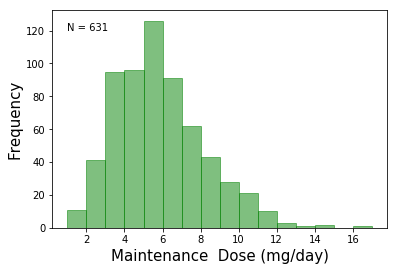

In [40]:
maintain_dose = df1[['maintain_dose']].values
plt.show()

num_bins = np.arange(1,18)
n, bins, patches = plt.hist(maintain_dose, num_bins, facecolor='green', alpha=0.5,edgecolor = 'green')

plt.xlabel('Maintenance  Dose (mg/day)',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.text(1,120,f"N = {maintain_dose.shape[0]}")
plt.savefig("maintenancedose.png", dpi=500)

mean_maintain_dose = np.mean(maintain_dose)
median_maintain_dose = np.median (maintain_dose)
Q3_maintain_dose, Q1_maintain_dose = np.percentile(maintain_dose, [75 ,25])
print([mean_maintain_dose,median_maintain_dose,Q1_maintain_dose,Q3_maintain_dose])

In [41]:
weight = dfall.Weight.values

mean_weight = np.mean(weight)
median_weight = np.median (weight)
Q1_weight, Q3_weight = np.percentile(weight, [25 ,75])
print([mean_weight,median_weight,Q1_weight,Q3_weight])

[91.07889627950112, 87.08973504000001, 74.84274105, 105.68702221000001]
